# Non-Bayes Models
#### Tabular: Logistic Regression, SI LSx, CIx
#### Image: CIb 
#### Tabular + image: CIb + LSx

In [15]:
# packages
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,initializers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import  Dense
from sklearn import preprocessing
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.regularizers import l2
from numpy.random import normal
import sys
from numpy import save, load
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img
#%load_ext autoreload
#%autoreload 2
#functions
from functions.scoreCI import score_ci
from functions.logScore import logScore
from functions.plot_rocCurve import plot_roc
##print versions
print("Python version")
print (sys.version)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )

Python version
3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Num GPUs Available:  1
Tensorflow version:  2.4.1


####  Import prepared tabular and image data 

In [3]:
#import data
#prepared patients metadata missing values age filled with mean value
dat = pd.read_csv('../thesis/patientData.csv')
#path of resized images
train_dir = "../thesis/trainRes/"
# add image path to patients
dat['path'] = train_dir + dat.image_name + ".jpg"
### check if missing data is removed 
#dat.isnull().sum()

In [4]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)
# 80% training data, 20% test data
train_idx = idx[:int(len(dat)*0.8)]
test_idx = idx[int(len(dat)*0.8):]
# 20% of training as validation
valid_idx = train_idx[:int(len(train_idx)*0.2)] 
train_idx = train_idx[int(len(train_idx)*0.2):]
print(train_idx.shape, valid_idx.shape, test_idx.shape)

(21200,) (5300,) (6626,)


In [5]:
X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
X_trainAge = dat.iloc[train_idx]
X_trainAge = X_train.loc[:, X_train.columns.intersection(['age_approx'])]
X_validAge= dat.iloc[valid_idx]
X_validAge = X_valid.loc[:, X_train.columns.intersection(['age_approx'])]
X_testAge= dat.iloc[test_idx]
X_testAge = X_test.loc[:, X_train.columns.intersection(['age_approx'])]
print(X_trainAge.shape, X_validAge.shape, X_testAge.shape)
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]
print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 1) (5300, 1) (6626, 1)
(21200, 1) (5300, 1) (6626, 1)


In [6]:
# save image path
train_files = X_train.path
val_files = X_valid.path
test_files = X_test.path

# target_size: images size 128x128
# img_to_array image als array transformieren
train_imgs = [img_to_array(load_img(img)) for img in train_files]
validation_imgs = [img_to_array(load_img(img)) for img in val_files]
test_imgs = [img_to_array(load_img(img)) for img in test_files]

train_imgs = np.array(train_imgs)
train_labels = y_train
validation_imgs = np.array(validation_imgs)
val_labels = y_valid
test_imgs = np.array(test_imgs)
test_labels = y_test

print('Train dataset shape:', train_imgs.shape, '\tValidation dataset shape:', validation_imgs.shape,'\Test dataset shape:', test_imgs.shape)


Train dataset shape: (21200, 128, 128, 3) 	Validation dataset shape: (5300, 128, 128, 3) \Test dataset shape: (6626, 128, 128, 3)


In [7]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled  = test_imgs.astype('float32')
train_labels = train_labels.astype("float32")
val_labels = val_labels.astype("float32")
val_labels = val_labels.astype("float32")
#scale pixel zwischen 0 und 1
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255
#plt.imshow(train_imgs_scaled[0])

In [8]:
### standardized patients age
def standard(data):
    mean = np.mean(data)
    std = np.std(data)
    standard = (data - mean) / std
    return standard
standAgeTr = standard(X_trainAge)
standAgeVal = standard(X_validAge)
standAgeTe= standard(X_testAge)

np.std(standAgeTr), np.mean(standAgeTr)

(age_approx    1.0
 dtype: float64,
 age_approx    1.628009e-16
 dtype: float64)

## Functions

In [9]:
"""
Calculate 95% confidence interval 
"""
def _conf_interval(ratio, std_error):
   

    _lci = ratio - 1.96*std_error
    _uci = ratio + 1.96*std_error

    lci = round(_lci, 3)
    uci = round(_uci, 3)

    return (lci, uci)

# add two components
def modelOn(X, X_meta):

    added = tf.keras.layers.Add()([X_meta.output, X.output]) ###
    out = tf.math.sigmoid(added)
    model = keras.Model(inputs = [X_meta.input, X.input], outputs = out)
    return model

## 2D CNN only: CIb

In [10]:
## Complex shift image
def complexIntercept(X):
    initializer = keras.initializers.HeNormal(seed = 2802)
    
    in_ = keras.Input(shape = X.shape[1:], name = "inImg")

    x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(in_)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
                        
    x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    
    out_ = layers.Dense(1, activation = "sigmoid")(x)  
    
    imageMod = Model(in_, out_)
    return imageMod

In [ ]:
# configuration
batch_size = 256 
epochs = 50
input_shape = (128, 128, 3)
opt = RMSprop() 
# train three times
for i in range(3):
    
    # define model and compile
    model = complexIntercept(train_imgs_scaled)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = opt,
                  metrics = ['AUC'])
 
    # train
    results = model.fit(x=train_imgs_scaled,
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=batch_size,
                        epochs = epochs,
                        verbose= True,
                       )   
    
    # save results
    dat = pd.DataFrame({'train_loss': results.history['loss'], 'train_acc': results.history['val_auc'], 
                        'test_loss': results.history['val_loss'], 'test_acc': results.history['val_auc']})
    dat.to_csv('run' + str(i) + '..thesis/history.csv', index=False)

    
    pred = model.predict(test_imgs_scaled)
    out = pd.DataFrame(pred, columns = ['p_0'])
    out.to_csv('run' + str(i) + '../thesis/test_predictions.csv', index=False)

### Performance

In [11]:
# load predictions
predrun0 = pd.read_csv('../thesis/performance/CNN_Runs/run0/test_predictions.csv')
p0= predrun0.values
predrun1 = pd.read_csv('../thesis/performance/CNN_Runs/run1/test_predictions.csv')
p1= predrun1.values
predrun2 = pd.read_csv('../thesis/performance/CNN_Runs/run2/test_predictions.csv')
p2= predrun2.values
### average predictions of 3 runs
meanPreds= [(g + h + u) / 3 for g, h,u in zip(p0, p1,p2)]
meanpreds = pd.DataFrame(meanPreds, columns = ['meanPreds'])
ravelPred = meanpreds.values.ravel()

In [12]:
# log score
logScore(y_test, meanpreds.values)

-0.07796855663926325

In [13]:
# AUC 
nn_fpr_LRS, nn_tpr_LRS, nn_thresholds_LR = roc_curve(test_labels, meanpreds)
scoreCSLS, ci_lowerCSLS, ci_upperCSLS, scoresCSLS=score_ci(test_labels, ravelPred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(scoreCSLS, ci_lowerCSLS, ci_upperCSLS))

AUC=0.81, 95% CI: 0.78-0.84


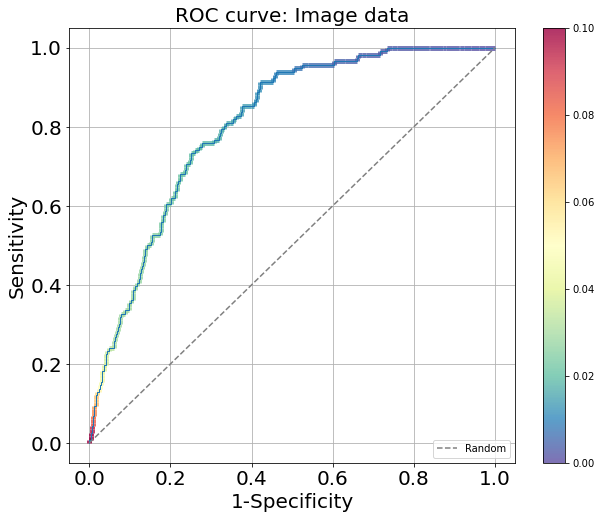

In [19]:
roc_dataImage =  nn_tpr_LRS, nn_fpr_LRS, nn_thresholds_LR
plot_roc(*roc_dataImage)
plt.grid()
plt.title("ROC curve: Image data",size = 20)
plt.savefig("../thesis/plots/interpret/ROCImage.pdf")

In [11]:
# load loss
loss0 = pd.read_csv('../thesis/performance/CNN_Runs/run0/history.csv')
loss1 = pd.read_csv('../thesis/performance/CNN_Runs/run1/history.csv')
loss2 = pd.read_csv('../thesis/performance/CNN_Runs/run2/history.csv')

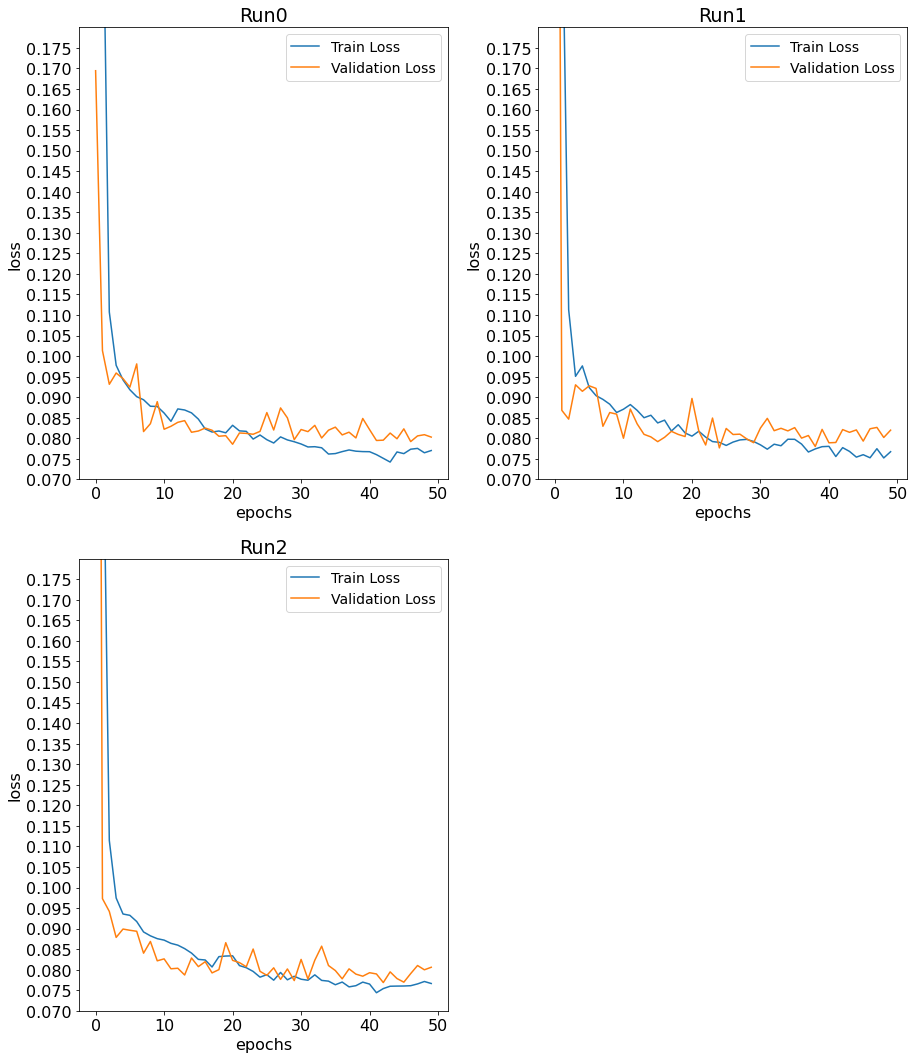

In [13]:
plt.figure(figsize=(13,15))
plt.rcParams.update(({'font.size': 16}))
plt.subplot(221)
plt.plot(loss0['train_loss'],label="Train Loss")
plt.plot(loss0['test_loss'], label="Validation Loss")
plt.legend(fontsize=14)
plt.title("Run0")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.18)
plt.yticks(np.arange(0.07, 0.18, 0.005))
plt.legend(fontsize=14)
plt.subplot(222)
plt.plot(loss1['train_loss'],label="Train Loss")
plt.plot(loss1['test_loss'], label="Validation Loss")
plt.legend(fontsize=14)
plt.title("Run1")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.18)
plt.yticks(np.arange(0.07, 0.18, 0.005))
plt.legend(fontsize=14)
plt.subplots_adjust( hspace=0.5)
plt.subplot(223)

plt.plot(loss2['train_loss'],label="Train Loss")
plt.plot(loss2['test_loss'], label="Validation Loss")
plt.title("Run2")
plt.legend(fontsize=14)
plt.ylim(0.07,0.18)
plt.yticks(np.arange(0.07, 0.18, 0.005))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("../thesis/plots/interpret/CNNs_Runs.pdf")
plt.show()

## Tabular Data SI LSx

### 1. Logistic Regression ML

In [ ]:
# ML-estimation logistic regression
from sklearn.linear_model import LogisticRegression
modelLog = LogisticRegression()
modelLR = modelLog.fit(standAgeTr,train_labels)
predLR = modelLR.predict_proba(standAgeTe)

In [18]:
# 95% CI 
feature_cols = ["age_approx"]
X =  pd.get_dummies(standAgeTr[feature_cols])# Features

# Design matrix 
X_design = np.hstack([np.ones((X.shape[0], 1)), X])
pred = modelLR.predict_proba(X)
# Initiate matrix of 0's
V = np.diagflat(np.product(pred, axis=1))

# Covariance matrix
covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
#print("Covariance matrix: ", covLogit)
# Standard errors
#print("Standard errors: ", np.sqrt(np.diag(covLogit)))
std_error = np.sqrt(np.diag(covLogit))
ratio = modelLR.coef_.item(0)
_conf_interval(ratio, std_error[1])

(0.598, 0.809)

In [19]:
predictions=predLR[:, 1].reshape(6626,1)
# log score
logScore(test_labels, predictions)

-0.08503367252541669

In [20]:
# AUC 
nn_fpr_LRS, nn_tpr_LRS, nn_thresholds_LR = roc_curve(test_labels, predLR[:, 1])
scoreCSLS, ci_lowerCSLS, ci_upperCSLS, scoresCSLS=score_ci(test_labels, predLR[:, 1], score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(scoreCSLS, ci_lowerCSLS, ci_upperCSLS))

AUC=0.66, 95% CI: 0.61-0.71


## 2. Logistic regression as NN

In [ ]:
model = Sequential()
model.add(Dense(units=1,kernel_initializer='glorot_uniform', activation='sigmoid',kernel_regularizer=l2(0.)))
model.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['AUC'])
model.fit(standAgeTr, train_labels, epochs=100, validation_data=(standAgeVal, val_labels))
model.save('../MA/LRNN.h5')    
# save results
dat = pd.DataFrame({'train_loss': model.history.history['loss'], 'train_acc': model.history.history['val_auc'], 
                        'val_loss': model.history.history['val_loss'], 'val_acc': model.history.history['val_auc']})
dat.to_csv('../thesis/RunsSILS/history.csv', index=False)


pred = model.predict(standAgeTe)
out = pd.DataFrame(pred, columns = ['p_0'])
out.to_csv('../thesis/RunsSILS/test_predictions.csv', index=False)
    
beta= model.get_weights()[0]
    # save to npy file
save('../thesis/RunsSILS/beta.npy', beta)

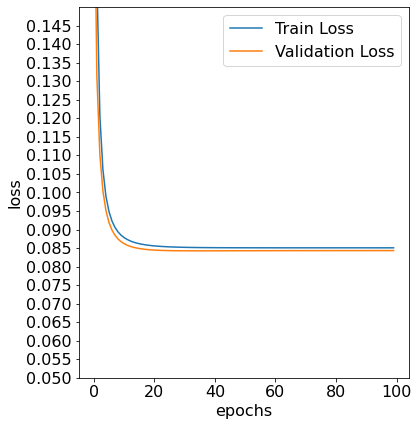

In [41]:
modelLR_NN = keras.models.load_model('../thesis/models/LRNN.h5')
loss_0 = pd.read_csv('../thesis/performance/RunsSILS/history.csv')
plt.figure(figsize=(13,15))
plt.subplot(221)
plt.plot(loss_0['train_loss'],label="Train Loss")
plt.plot(loss_0['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.05,0.15)
plt.yticks(np.arange(0.05, 0.15, 0.005))
plt.legend()

#plt.savefig("../thesis/plots/interpret/LOSS_SILSx.pdf")
plt.show()

In [27]:
y_predLR_NN = modelLR_NN.predict(standAgeTe)

nn_fpr_LRS, nn_tpr_LRS, nn_thresholds_LR = roc_curve(test_labels, y_predLR_NN)
aucLR = auc(nn_fpr_LRS, nn_tpr_LRS)
log_LR= logScore(test_labels, y_predLR_NN)
log_LR

-0.08500731068995995

In [28]:
#scoreSILS, ci_lowerSILS, ci_upperSILS, scoresSILS=score_ci(test_labels, y_predLR_NN.ravel(), score_fun=roc_auc_score)
#print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(scoreSILS, ci_lowerSILS, ci_upperSILS))

score, ci_lower, ci_upper, scores =score_ci(test_labels, y_predLR_NN.ravel(), score_fun=roc_auc_score)
nn_fpr_SILS, nn_tpr_SILS, nn_thresholds_SILS = roc_curve(test_labels, y_predLR_NN.ravel())
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

AUC=0.66, 95% CI: 0.61-0.71


## Tabular Data CIx
### Comparison to LSx

In [15]:
##complex shift

inCov = keras.Input(shape = standAgeTr.shape[1:])
h = layers.Dense(3, activation = 'tanh', name = 'hid',use_bias=False)(inCov)  
lin = layers.Dense(1, activation = 'linear', name = 'lin',use_bias=False)(h)
outCov = layers.Dense(1, activation = 'sigmoid')(lin)
CS = keras.Model(inputs = inCov, outputs = outCov)

In [ ]:
epochs = 25 
CS.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", run_eagerly=False)
CS.fit(x = standAgeTr,
       y = y_train, 
       epochs=epochs, 
       validation_data = (standAgeVal,y_valid), verbose=True)
#CS.save('../thesis/CSx.h5')

In [30]:
CS = keras.models.load_model('../thesis/CSx.h5') 
sortX = standAgeTe.sort_values("age_approx", ascending = True)
intermediate_layer_model = Model(inputs=CS.input, outputs=CS.layers[2].output) ## get linear output
y_pred_VIMLTS = intermediate_layer_model.predict(sortX)

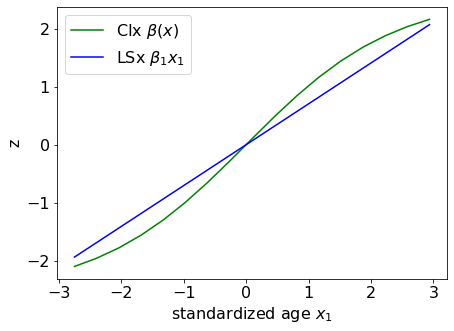

In [32]:
#Load beta of linear shift
slope = np.load('../thesis/performance/RunsSILS/beta.npy').item(0)
z2 = [ x for x in y_pred_VIMLTS] ## complex shift for each age differen
z1 = [ slope *x for x in sortX.values] # Linear shift

plt.figure(figsize=(7,5))
plt.rcParams.update(({'font.size': 16}))
plt.plot(sortX,z2, label = ("CIx $\\beta(x)$"),color="g")
plt.plot(sortX,z1, label = ("LSx $\\beta_1x_1$"),color="b")
plt.xlabel("standardized age $x_1$")
plt.ylabel("z")
plt.legend()
plt.show()
#plt.savefig("../thesis/plots/interpret/CoompareCSx_SILSx.pdf")

In [33]:
preds= CS.predict(standAgeTe)
logScore(test_labels, preds)

-0.08525928872575043

In [34]:
predsAUC = preds.ravel()
scoreCSLS, ci_lowerCSLS, ci_upperCSLS, scoresCSLS=score_ci(test_labels, predsAUC, score_fun=roc_auc_score)
nn_fpr_CS, nn_tpr_CS, nn_thresholds_CS = roc_curve(test_labels, predsAUC)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(scoreCSLS, ci_lowerCSLS, ci_upperCSLS))

AUC=0.66, 95% CI: 0.61-0.70


<h3> Combined Model: CIb LSx </h3>

In [21]:
## Complex shift image

initializer = keras.initializers.HeNormal(seed = 2802)
    
in_ = keras.Input(shape = (128,128,3), name = "inImg")

x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(in_)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
                        
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
    
out_ = layers.Dense(1, activation = "linear")(x) 
    
imageMod = Model(in_, out_)

In [22]:
# Warmstart with solution of LR
slope = np.load('../thesis/performance/RunsSILS/beta.npy').item(0)
initializer = tf.keras.initializers.Constant(slope) #### solution from LR 
inCov = keras.Input(shape = standAgeTr.shape[1:], name = 'inCov')
outCov = layers.Dense(1,kernel_initializer=initializer, activation = 'linear', name = 'outCov', use_bias = False)(inCov)

nn_x = keras.Model(inputs = inCov, outputs = outCov)


##add noise of weights
def add_noise(model):
    for layer in model.trainable_weights:
        noise = normal(loc=0.0, scale=0.1, size=layer.shape)
        layer.assign_add(noise)
add_noise(nn_x)

In [ ]:
opt = RMSprop()
epochs = 50
batch_size= 128
for i in range(3):
    
    # define model and compile
    model = modelOn(nn_x, imageMod)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = opt,
                  metrics = ['AUC'])
    

    
    # train
    results = model.fit(x=[train_imgs_scaled, standAgeTr],
                        y = train_labels,
                        validation_data = ([validation_imgs_scaled, standAgeVal], val_labels),
                        batch_size=batch_size,
                        epochs = epochs,  
                        verbose= True,
                       )   
    
    # save results
    dat = pd.DataFrame({'train_loss': results.history['loss'], 'train_acc': results.history['val_auc'], 
                        'val_loss': results.history['val_loss'], 'val_acc': results.history['val_auc']})
    dat.to_csv('../thesis/RunsCILS/'+'Run' + str(i) + '/history.csv', index=False)

    xtest = {'inImg': test_imgs_scaled, 'inCov': standAgeTe}
    pred = model.predict(xtest)
    out = pd.DataFrame(pred, columns = ['p_0'])
    out.to_csv('../thesis/RunsCILS/'+'Run' + str(i) + '/test_predictions.csv', index=False)
    
    beta= nn_x.get_weights()
    # save to npy file
    save('../thesis/RunsCILS/'+'Run' + str(i) + '/beta.npy', beta)

In [140]:
#modelCombined = model.save('../MA/ModelCSLS.h5')
#modelCombined = keras.models.load_model('../MA/ModelCSLS.h5')

In [25]:
predrun0 = pd.read_csv('../thesis/performance/RunsCILS/Run0/test_predictions.csv')
p0= predrun0.values
predrun1 = pd.read_csv('../thesis/performance/RunsCILS/Run1/test_predictions.csv')
p1= predrun1.values
predrun2 = pd.read_csv('../thesis/performance/RunsCILS/Run2/test_predictions.csv')
p2= predrun2.values
loss_0 = pd.read_csv('../thesis/performance/RunsCILS/Run0/history.csv')

loss_1 = pd.read_csv('../thesis/performance/RunsCILS/Run1/history.csv')

loss_2 = pd.read_csv('../thesis/performance/RunsCILS/Run2/history.csv')

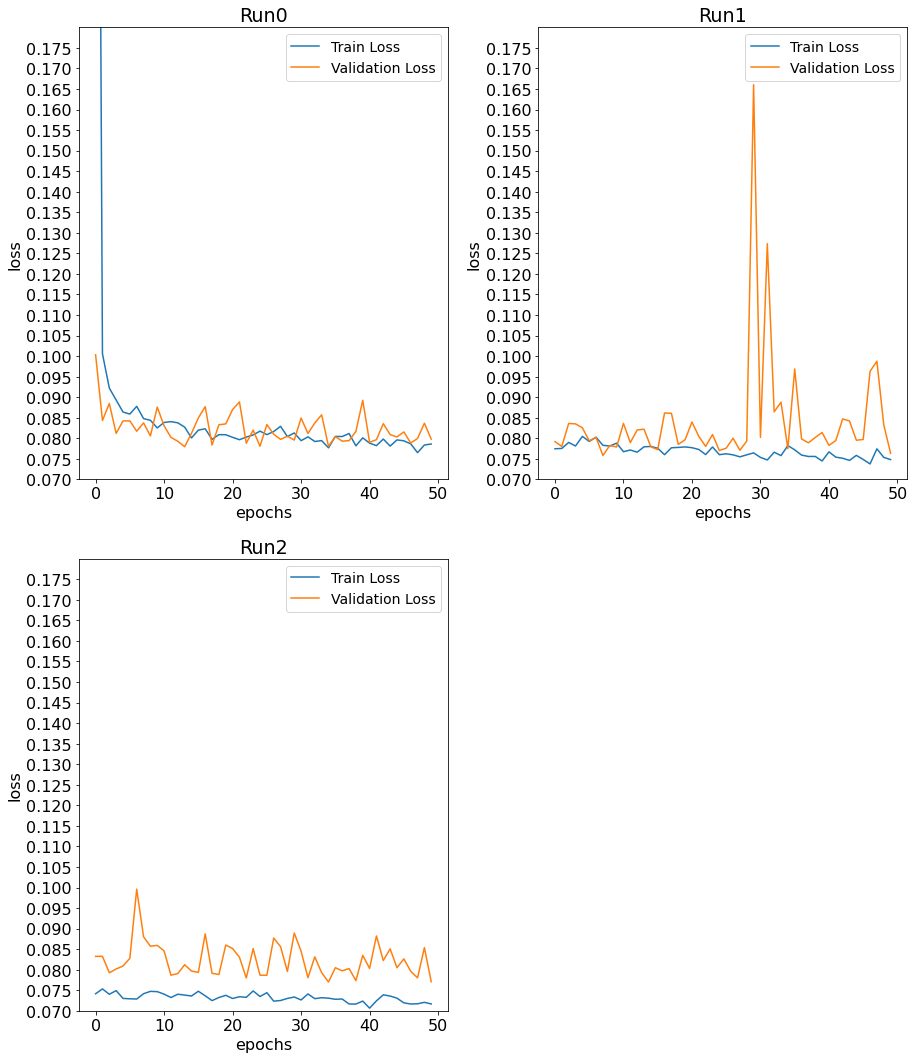

In [36]:
plt.figure(figsize=(13,15))
plt.rcParams.update(({'font.size': 16}))
plt.subplot(221)
plt.plot(loss_0['train_loss'],label="Train Loss")
plt.plot(loss_0['val_loss'], label="Validation Loss")
plt.legend(fontsize=14)
plt.title("Run0")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.18)
plt.yticks(np.arange(0.07, 0.18, 0.005))
plt.legend(fontsize=14)
plt.subplot(222)
plt.plot(loss_1['train_loss'],label="Train Loss")
plt.plot(loss_1['val_loss'], label="Validation Loss")
plt.legend(fontsize=14)
plt.title("Run1")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.18)
plt.yticks(np.arange(0.07, 0.18, 0.005))
plt.legend(fontsize=14)
plt.subplots_adjust( hspace=0.5)
plt.subplot(223)

plt.plot(loss_2['train_loss'],label="Train Loss")
plt.plot(loss_2['val_loss'], label="Validation Loss")
plt.title("Run2")
plt.legend(fontsize=14)
plt.ylim(0.07,0.18)
plt.yticks(np.arange(0.07, 0.18, 0.005))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("../thesis/plots/interpret/CILS_LossCurves3Runs.pdf")
plt.show()

In [27]:
### average predictions
meanPreds= [(g + h + u) / 3 for g, h,u in zip(p0, p1,p2)]
meanpreds = pd.DataFrame(meanPreds, columns = ['meanPreds'])

In [28]:
logScore(test_labels,meanpreds.values)

-0.07453594169446273

In [29]:
meanPredsAuc= meanpreds.values.ravel()
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanPredsAuc, score_fun=roc_auc_score)
nn_fpr_CSls, nn_tpr_CSls, nn_thresholds_CSls = roc_curve(test_labels, meanPredsAuc)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

AUC=0.84, 95% CI: 0.80-0.87


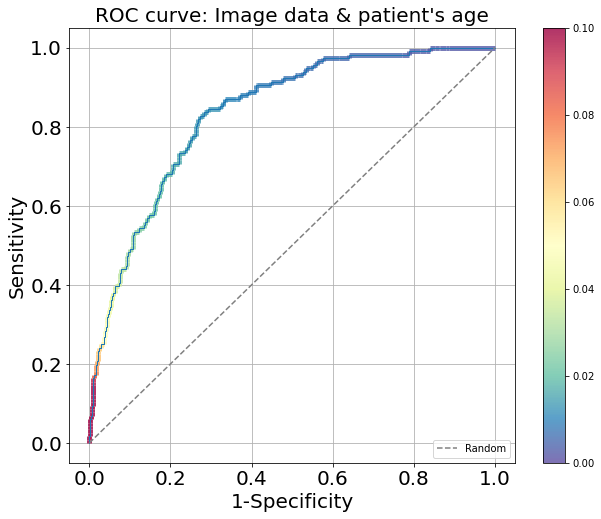

In [31]:
roc_dataCombined =  nn_tpr_CSls, nn_fpr_CSls, nn_thresholds_CSls
plot_roc(*roc_dataCombined)
plt.grid()
plt.title("ROC curve: Image data & patient's age",size = 20)
plt.savefig("../thesis/plots/interpret/ROCBoth.pdf")

In [42]:
beta0 = load('../thesis/performance/RunsCILS/Run0/beta.npy')
beta1 = load('../thesis/performance/RunsCILS/Run1/beta.npy')
beta2 = load('../thesis/performance/RunsCILS/Run2/beta.npy')
### average predictions
meanBeta= [(g + h + u) / 3 for g, h,u in zip(beta0, beta1,beta2)]
meanBeta

[array([[0.6045156]], dtype=float32)]

## All in one roc curve

In [43]:
#### model CIb
predrun0 = pd.read_csv('../thesis/performance/CNN_Runs/run0/test_predictions.csv')
p0= predrun0.values
predrun1 = pd.read_csv('../thesis/performance/CNN_Runs/run1/test_predictions.csv')
p1= predrun1.values
predrun2 = pd.read_csv('../thesis/performance/CNN_Runs/run2/test_predictions.csv')
p2= predrun2.values
### average predictions
meanPredsCIb= [(g + h + u) / 3 for g, h,u in zip(p0, p1,p2)]
meanpredsCIb = pd.DataFrame(meanPredsCIb, columns = ['meanPreds'])
meanPredsAucCIb= meanpredsCIb.values.ravel()
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanPredsAucCIb, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
nn_fpr_CIb, nn_tpr_CIb, nn_thresholds_CIb = roc_curve(test_labels, meanPredsAucCIb)

AUC=0.81, 95% CI: 0.78-0.84


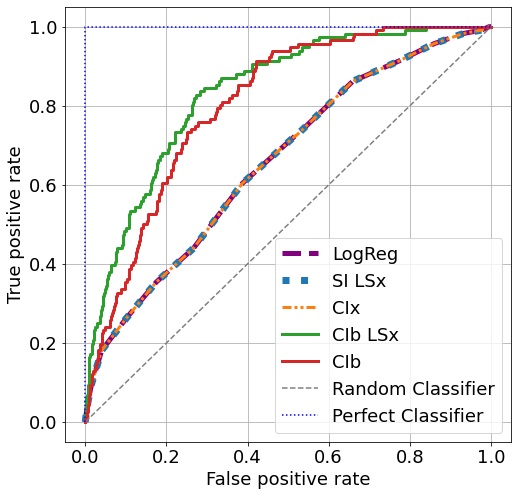

In [44]:
plt.figure(figsize=(8,8))
plt.rcParams.update(({'font.size': 18}))
plt.grid()
plt.plot(nn_fpr_LRS, nn_tpr_LRS, label='LogReg', linewidth=5,linestyle="dashed", color="purple")
###lay over each other: 
plt.plot(nn_fpr_SILS, nn_tpr_SILS, label="SI LSx",linewidth=7, linestyle ="dotted")
plt.plot(nn_fpr_CS, nn_tpr_CS, label="CIx",linewidth = 3,linestyle=(0,(3,1,1,1,1,1)))
##
plt.plot(nn_fpr_CSls, nn_tpr_CSls, label="CIb LSx",linewidth=3)
plt.plot(nn_fpr_CIb, nn_tpr_CIb, label='CIb',linewidth=3)

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='blue', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
#plt.savefig("../thesis/plots/interpret/ROCCurveAll.pdf")
plt.show()

In [45]:
%reload_ext version_information
%version_information tensorflow,numpy, pandas, matplotlib

Software versions
Python 3.9.7 64bit [GCC 7.5.0]
IPython 7.27.0
OS Linux 5.8.0 63 generic x86_64 with glibc2.32
tensorflow 2.4.1
numpy 1.21.2
pandas 1.3.3
matplotlib 3.4.3
Mon Nov 29 17:49:19 2021 CET